# Import libraries

In [18]:
import os, sys
import csv
import numpy as np
import matplotlib.pyplot as plt

# Setting

In [19]:
outdir = './output'
#datadir = '/Users/shadachi/Experiment/DOSUE/data/n9010a/2022-02-03/data'
#timesec_min = 1643847000
datadir = '/data/ms2840a/2022-02-07/data'
timesec_min = 1644220400
#filekey = 'timechangecheck_SWEEP'
#outsuffix = '_anritsuSWEEP'
#outsuffix = '_keysightSWEEP'
filekey = 'timechangecheck_FFT'
outsuffix = '_anritsuFFT'
#outsuffix = '_keysightFFT'
filekey2 = '.dat'
i_index = 4
unixtime_index = 5
csvType = 'TwoColumn'; # freq, dBm
#csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
#csvType = 'Keysight'; # Keysight Spectrum Analyzer USB: output
#csvType = 'OneColumn'; # dBm 
#csvType = 'TwoColumn'; # freq, dBm

freq_min = 19.999999 # [GHz]
freq_max = 20.000001 # [GHz]
nFreqAve = 10 
import matplotlib.cm as cm
colors = [ cm.hsv(i/10.0) for i in range(10) ] * 10

k_B = 1.380649e-23  # boltzmann const. [J/K]

def get_unix_time(_filename):
    unix_time = _filename.split('.')[0].split('_')[unixtime_index]
    return int(unix_time)

# Get filenames
all_filenames = os.listdir(datadir)
all_filenames = [ f for f in all_filenames if f != '']
_filenames = []
_indexs = []
for _filename in all_filenames:
    #print(_filename)
    if filekey in _filename and filekey2 in _filename:
        timesec = get_unix_time(_filename)
        if timesec < timesec_min: continue
        _filenames.append(_filename)
        _indexs.append(int(_filename.split('_')[i_index]))
        pass
    pass
print('# of _filenames, _indexs = ', len(_filenames), len(_indexs))
filenames = [''] * len(_filenames)
for _index, _filename in zip(_indexs, _filenames):
    print(_index-1)
    if filenames[_index-1] != '' :
        print(f'Error! filename for {_index-1} exists! ({filenames[_index-1]} v.s. {_filename})')
    filenames[_index-1] = _filename;
    pass;
print(filenames)

# Get elapsed time
timesecs = []
for filename in filenames:
    _time = get_unix_time(filename)
    timesecs.append(_time)
    pass
timesecs = np.array(timesecs)
timesecs = timesecs - timesecs[0]
labels = [ '{:.0f} min'.format(time/60.) for time in timesecs ]
print(f'timesecs = {timesecs}')
print(f'labels = {labels}')

# of _filenames, _indexs =  43 43
20
11
25
23
34
5
31
21
9
18
32
14
8
12
42
26
28
6
10
4
36
17
13
40
38
22
39
24
16
15
27
1
7
41
35
29
2
37
0
3
19
33
30
['SG20GHz_sweep_timechangecheck_FFT_1_1644220438.dat', 'SG20GHz_sweep_timechangecheck_FFT_2_1644221044.dat', 'SG20GHz_sweep_timechangecheck_FFT_3_1644221650.dat', 'SG20GHz_sweep_timechangecheck_FFT_4_1644222257.dat', 'SG20GHz_sweep_timechangecheck_FFT_5_1644222863.dat', 'SG20GHz_sweep_timechangecheck_FFT_6_1644223469.dat', 'SG20GHz_sweep_timechangecheck_FFT_7_1644224075.dat', 'SG20GHz_sweep_timechangecheck_FFT_8_1644224681.dat', 'SG20GHz_sweep_timechangecheck_FFT_9_1644225287.dat', 'SG20GHz_sweep_timechangecheck_FFT_10_1644225893.dat', 'SG20GHz_sweep_timechangecheck_FFT_11_1644226499.dat', 'SG20GHz_sweep_timechangecheck_FFT_12_1644227105.dat', 'SG20GHz_sweep_timechangecheck_FFT_13_1644227711.dat', 'SG20GHz_sweep_timechangecheck_FFT_14_1644228317.dat', 'SG20GHz_sweep_timechangecheck_FFT_15_1644228923.dat', 'SG20GHz_sweep_timechangecheck

# Define function to read csv datafile

In [20]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    freq0 = 0
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
                    
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [21]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [22]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [23]:
freqs_array = []
powers_array = []
for filename in filenames:
    _freq, _power = read_csv(f'{datadir}/{filename}', csvType)
    
    print(_freq)
    print(_power)
    # Select data between freq_min and freq_max
    _power = _power[_freq<=freq_max]
    _freq = _freq[_freq<=freq_max]
    _power = _power[_freq>=freq_min]
    _freq = _freq[_freq>=freq_min]
    
    freqs_array.append(_freq)
    powers_array.append(_power)
    pass

freqs_array = np.array(freqs_array)
powers_array = np.array(powers_array)

[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[2.82702601e-11 2.78695139e-11 2.82136510e-11 ... 3.59417495e-10
 3.57457937e-10 3.54321936e-10]
[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[8.38124552e-10 8.19952331e-10 8.01574022e-10 ... 6.91262658e-11
 7.18236625e-11 7.44269191e-11]
[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[7.17488797e-10 7.04698566e-10 6.90211818e-10 ... 6.90842616e-11
 6.62535195e-11 6.36648007e-11]
[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[6.87618278e-10 6.74612308e-10 6.61157411e-10 ... 1.54781077e-10
 1.49670360e-10 1.44183295e-10]
[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[3.11297956e-10 3.23081759e-10 3.35073142e-10 ... 9.83067787e-11
 1.03728508e-10 1.09531191e-10]
[19.999999  19.999999  19.999999  ... 20.0000015 20.0000015 20.0000015]
[7.82680371e-12 4.58924111e-12 2.21332644e-12 ... 2.35525268e-10
 2.36358385e-10 2.

In [24]:
print(freqs_array)
print(powers_array)
print(freqs_array)
print(powers_array)

[[19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]
 [19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]
 [19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]
 ...
 [19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]
 [19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]
 [19.999999   19.999999   19.999999   ... 20.00000099 20.000001
  20.000001  ]]
[[2.82702601e-11 2.78695139e-11 2.82136510e-11 ... 5.12150839e-11
  4.03491321e-11 3.10686067e-11]
 [8.38124552e-10 8.19952331e-10 8.01574022e-10 ... 4.17418698e-10
  3.97000912e-10 3.77486344e-10]
 [7.17488797e-10 7.04698566e-10 6.90211818e-10 ... 9.81100991e-11
  1.26015123e-10 1.56807441e-10]
 ...
 [2.71923962e-10 2.64990768e-10 2.57458868e-10 ... 1.58262288e-10
  1.48851998e-10 1.39825996e-10]
 [1.60240461e-10 1.44942120e-10 1.30413598e-10 ... 4.57455139e-10
  4.74378869e-10 4.91567602e-10]
 [1.93750526e-10 1.8

###  Plot Power [mW]

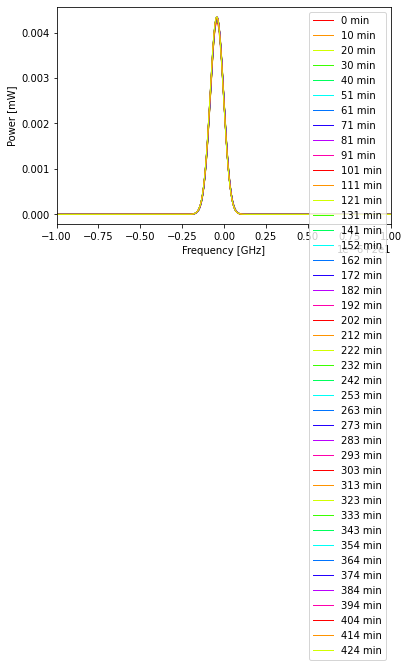

In [9]:
for i, filename in enumerate(filenames):
    plt.plot(freqs_array[i], powers_array[i], label=f'{labels[i]}', color=colors[i], marker='', markersize=0.5, linestyle='-', linewidth=1.0)
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_mW{outsuffix}.png')
plt.show()

[19.999999   19.999999   19.999999   19.99999901 19.99999901 19.99999901
 19.99999901 19.99999902 19.99999902 19.99999902 19.99999902 19.99999903
 19.99999903 19.99999903 19.99999903 19.99999904 19.99999904 19.99999904
 19.99999904 19.99999905 19.99999905 19.99999905 19.99999905 19.99999906
 19.99999906 19.99999906 19.99999906 19.99999907 19.99999907 19.99999907
 19.99999907 19.99999908 19.99999908 19.99999908 19.99999908 19.99999909
 19.99999909 19.99999909 19.99999909 19.9999991  19.9999991  19.9999991
 19.9999991  19.9999991  19.99999911 19.99999911 19.99999911 19.99999911
 19.99999912 19.99999912 19.99999912 19.99999912 19.99999913 19.99999913
 19.99999913 19.99999913 19.99999914 19.99999914 19.99999914 19.99999914
 19.99999915 19.99999915 19.99999915 19.99999915 19.99999916 19.99999916
 19.99999916 19.99999916 19.99999917 19.99999917 19.99999917 19.99999917
 19.99999918 19.99999918 19.99999918 19.99999918 19.99999919 19.99999919
 19.99999919 19.99999919 19.9999992  19.9999992  19.

[19.999999   19.999999   19.999999   19.99999901 19.99999901 19.99999901
 19.99999901 19.99999902 19.99999902 19.99999902 19.99999902 19.99999903
 19.99999903 19.99999903 19.99999903 19.99999904 19.99999904 19.99999904
 19.99999904 19.99999905 19.99999905 19.99999905 19.99999905 19.99999906
 19.99999906 19.99999906 19.99999906 19.99999907 19.99999907 19.99999907
 19.99999907 19.99999908 19.99999908 19.99999908 19.99999908 19.99999909
 19.99999909 19.99999909 19.99999909 19.9999991  19.9999991  19.9999991
 19.9999991  19.9999991  19.99999911 19.99999911 19.99999911 19.99999911
 19.99999912 19.99999912 19.99999912 19.99999912 19.99999913 19.99999913
 19.99999913 19.99999913 19.99999914 19.99999914 19.99999914 19.99999914
 19.99999915 19.99999915 19.99999915 19.99999915 19.99999916 19.99999916
 19.99999916 19.99999916 19.99999917 19.99999917 19.99999917 19.99999917
 19.99999918 19.99999918 19.99999918 19.99999918 19.99999919 19.99999919
 19.99999919 19.99999919 19.9999992  19.9999992  19.

[19.999999   19.999999   19.999999   19.99999901 19.99999901 19.99999901
 19.99999901 19.99999902 19.99999902 19.99999902 19.99999902 19.99999903
 19.99999903 19.99999903 19.99999903 19.99999904 19.99999904 19.99999904
 19.99999904 19.99999905 19.99999905 19.99999905 19.99999905 19.99999906
 19.99999906 19.99999906 19.99999906 19.99999907 19.99999907 19.99999907
 19.99999907 19.99999908 19.99999908 19.99999908 19.99999908 19.99999909
 19.99999909 19.99999909 19.99999909 19.9999991  19.9999991  19.9999991
 19.9999991  19.9999991  19.99999911 19.99999911 19.99999911 19.99999911
 19.99999912 19.99999912 19.99999912 19.99999912 19.99999913 19.99999913
 19.99999913 19.99999913 19.99999914 19.99999914 19.99999914 19.99999914
 19.99999915 19.99999915 19.99999915 19.99999915 19.99999916 19.99999916
 19.99999916 19.99999916 19.99999917 19.99999917 19.99999917 19.99999917
 19.99999918 19.99999918 19.99999918 19.99999918 19.99999919 19.99999919
 19.99999919 19.99999919 19.9999992  19.9999992  19.

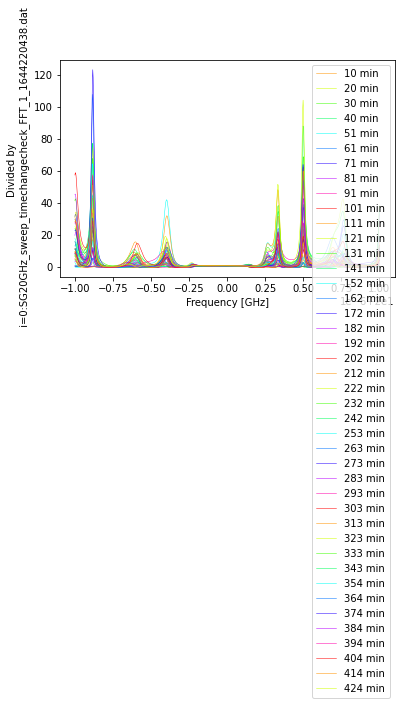

In [10]:
freq0 = freqs_array[0]
power0 = powers_array[0]
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    print(freq0)
    print(freqs_array[i])
    print(powers_array[i])
    power_interp = freq_interpolate(freq0, freqs_array[i], powers_array[i])
    div_power =power_interp/power0
    plt.plot(freq0, div_power, label=f'{labels[i]}', color=colors[i], marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_div{outsuffix}.png')
plt.show()

###  Plot Power [dBm]

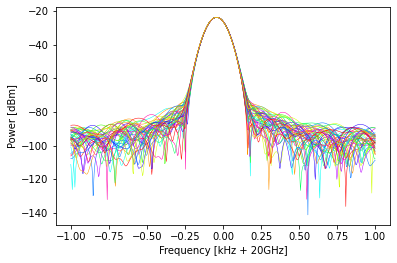

In [39]:
#for i, filename in enumerate(filenames):
#    power_dBm = np.log10(powers_array[i])*10.
#    plt.plot(freqs_array[i]*1.e+9+40., power_dBm, label=f'{labels[i]}', color=colors[i], marker='', markersize=0.5, linestyle='-', linewidth=0.5)
#    pass
#for i, filename in enumerate(filenames[:1]):
for i, filename in enumerate(filenames):
    power_dBm = np.log10(powers_array[i])*10.
    #plt.plot(freqs_array[i]*1.e+9+40., power_dBm, label=f'{labels[i]}', color=colors[i], marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    plt.plot((freqs_array[i]-20)*1e+6, power_dBm, label=f'{labels[i]}', color=colors[i], marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass
#plt.xlabel('Frequency [Hz]') #x軸の名前
plt.xlabel('Frequency [kHz + 20GHz]') #x軸の名前
plt.ylabel('Power [dBm]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.xlim(20e+9-100,20e+9+100) #x軸範囲指定
#plt.ylim(-26.7,-23.7) #y軸範囲指定
#plt.xticks([-1,0,1])
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

#plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_dBm{outsuffix}.png')
plt.show()

### Plot averaged power

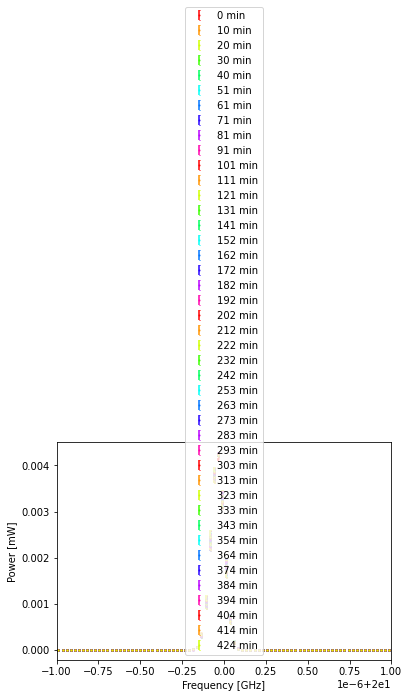

In [12]:
## Averaging
freqs_ave_array = []
powers_ave_array = []
powers_ave_err_array = []
for i, filename in enumerate(filenames):
    _freq_ave, tmp = freq_average(freqs_array[i], naverage=nFreqAve)
    _power_ave, _power_ave_err = freq_average(powers_array[i], naverage=nFreqAve)
    freqs_ave_array.append(_freq_ave)
    powers_ave_array.append(_power_ave)
    powers_ave_err_array.append(_power_ave_err)
    pass
freqs_ave_array = np.array( freqs_ave_array )
powers_ave_array = np.array( powers_ave_array )
powers_ave_err_array = np.array( powers_ave_err_array )

## Plotting
for i, filename in enumerate(filenames):
    plt.errorbar(freqs_ave_array[i], powers_ave_array[i], yerr=powers_ave_err_array[i], 
                 label=f'{labels[i]}', capsize=0.5, fmt='o', markersize=1, 
                 ecolor=colors[i], markeredgecolor = colors[i], color=colors[i])
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
plt.legend()

plt.savefig(f"{outdir}/compare_multiple_power_average{outsuffix}.png")
plt.show()

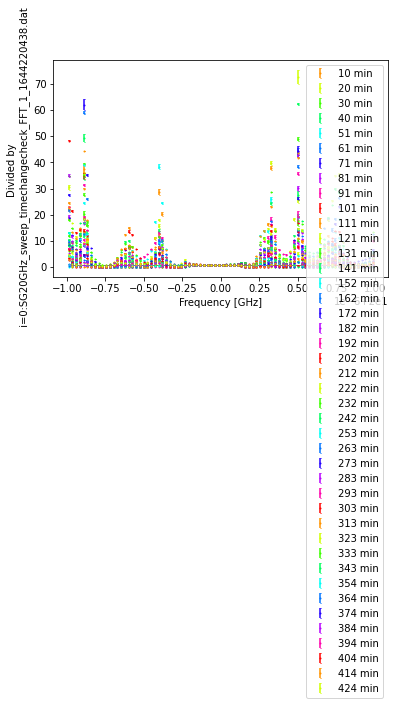

In [13]:
freq0 = freqs_ave_array[0]
power0 = powers_ave_array[0]
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_array[i])
    power_err_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_err_array[i])
    div_power = power_interp/power0
    div_power_err = power_err_interp/power0
    plt.errorbar(freq0, div_power, yerr=div_power_err, 
                 label=f'{labels[i]}', capsize=0.5, fmt='o', markersize=1, 
                 ecolor=colors[i], markeredgecolor = colors[i], color=colors[i])
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定
plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power-ave_div{outsuffix}.png')
plt.show()

# Time-dependency

[    0   606  1212  1819  2425  3031  3637  4243  4849  5455  6061  6667
  7273  7879  8485  9091  9697 10303 10909 11515 12121 12727 13333 13940
 14546 15152 15758 16364 16970 17576 18182 18788 19394 20000 20606 21212
 21818 22425 23031 23637 24243 24849 25455]
[19.99999995703125, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.99999995703125, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.999999959472657, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.999999959472657, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 19.99999995703125, 

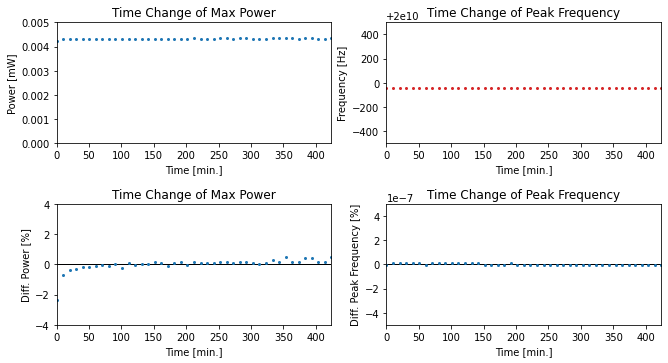

In [38]:
## Plotting
center_freq = []
max_power = []
for i, filename in enumerate(filenames):
    _freq = freqs_array[i]
    _power = powers_array[i]
    _power_max = np.max(_power)
    max_power.append(_power_max)
    center_freq.append(_freq[_power==_power_max][0])
    pass
print(timesecs)
print(center_freq)
print(max_power)
    
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,6)
fig.tight_layout(rect=[0,0,1,1]);
plt.subplots_adjust(wspace=0.2, hspace=0.5, left=0.15, right=0.85,bottom=0.15, top=0.85)

axs[0][0].errorbar(timesecs/60., max_power, yerr=None, 
             label=f'Max Power Time Dep.', capsize=0.0, fmt='o', markersize=2, 
             linestyle='', color='tab:blue')
axs[0][0].set_title('Time Change of Max Power')
axs[0][0].set_xlabel('Time [min.]') #x軸の名前
axs[0][0].set_ylabel('Power [mW]') #y軸の名前
axs[0][0].set_xlim([0., max(timesecs/60.)])
axs[0][0].set_ylim([0., 0.005])

axs[1][0].plot([0.,max(timesecs/60.)], [0.,0.], linestyle='-', color='k', linewidth=1.)
axs[1][0].errorbar(timesecs/60., np.multiply(max_power, 100./np.mean(max_power))-100., yerr=None, 
             label=f'Max Power Time Dep.', capsize=0.0, fmt='o', markersize=2, 
             linestyle='', color='tab:blue')
axs[1][0].set_title('Time Change of Max Power')
axs[1][0].set_xlabel('Time [min.]') #x軸の名前
axs[1][0].set_ylabel('Diff. Power [%]') #y軸の名前
axs[1][0].set_xlim([0., max(timesecs/60.)])
axs[1][0].set_ylim([-4., 4.])

axs[0][1].errorbar(timesecs/60., np.multiply(center_freq, 1.e+9), yerr=None, 
             label=f'Peak Freq. Time Dep.', capsize=0.0, fmt='o', markersize=2, 
             linestyle='', color='tab:red')
axs[0][1].set_title('Time Change of Peak Frequency')
axs[0][1].set_xlabel('Time [min.]') #x軸の名前
axs[0][1].set_ylabel('Frequency [Hz]') #y軸の名前
axs[0][1].set_xlim([0., max(timesecs/60.)])
axs[0][1].set_ylim([20e+9-500, 20e+9+500])

axs[1][1].plot([0.,max(timesecs/60.)], [0.,0.], linestyle='-', color='k', linewidth=1.)
axs[1][1].errorbar(timesecs/60., np.multiply(center_freq, 100./np.mean(center_freq))-100., yerr=None, 
             label=f'Peak Freq. Time Dep.', capsize=0.0, fmt='o', markersize=2, 
             linestyle='', color='tab:blue')
axs[1][1].set_title('Time Change of Peak Frequency')
axs[1][1].set_xlabel('Time [min.]') #x軸の名前
axs[1][1].set_ylabel('Diff. Peak Frequency [%]') #y軸の名前
axs[1][1].set_xlim([0., max(timesecs/60.)])
axs[1][1].set_ylim([-5.e-7, 5.e-7])


plt.savefig(f"{outdir}/compare_multiple_timechange{outsuffix}.png")
plt.show()